# Kaggle dogs-vs-cats competition

### Easy steps to train a world-class image classifier:
1. freeze all but last layer
1. turn on caching of frozen layers
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting
1. Check validation results, compare to other models
1. Select best model, retrain entirely on full data set

### Setup

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import pathlib
import multiprocessing as mp
from sklearn.metrics import confusion_matrix
# from tqdm import tqdm_notebook as tqdm

torch.cuda.is_available()
torch.backends.cudnn.enabled

True

True

### Define utility functions

In [3]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)

def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))        


def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)


### Get data

In [4]:
PATH = '/home/paperspace/data/kaggle/dogs-vs-cats/'
!mkdir -p {PATH}
!kaggle competitions download -c dogs-vs-cats -p {PATH}
!ls {PATH}

  0%|                                               | 0.00/86.8k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 86.8k/86.8k [00:00<00:00, 33.6MB/s]
 99%|███████████████████████████████████████▋| 269M/271M [00:04<00:00, 59.9MB/s]
100%|████████████████████████████████████████| 271M/271M [00:04<00:00, 57.0MB/s]
 99%|███████████████████████████████████████▌| 538M/543M [00:09<00:00, 72.7MB/s]
100%|████████████████████████████████████████| 543M/543M [00:09<00:00, 61.3MB/s]
sampleSubmission.csv  test1.zip  train.zip


In [5]:
!unzip -q '{PATH}/*.zip' -d {PATH}
!ls {PATH}


2 archives were successfully processed.
sampleSubmission.csv  test1  test1.zip	train  train.zip


### Inspect and prepare data

In [6]:
TRAIN_PATH = os.path.join(PATH,'train')
os.listdir(TRAIN_PATH)[:3]
full_train = glob(os.path.join(TRAIN_PATH, '*.jpg'))
len(full_train)

['cat.2648.jpg', 'dog.11788.jpg', 'dog.11304.jpg']

25000

In [7]:
dogs = glob(os.path.join(TRAIN_PATH, 'dog*.jpg'))
cats = glob(os.path.join(TRAIN_PATH, 'cat*.jpg'))

#### Take a look

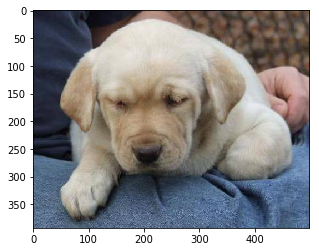

In [8]:
dog_img = plt.imread(dogs[0])
plt.imshow(dog_img);

### Shuffle training data, move some to validation set, place in folders according to label

In [9]:
# shuffle images
np.random.shuffle(dogs)
np.random.shuffle(cats)

# create new paths
VALID_PATH = os.path.join(PATH, 'valid')
TRAIN_DOG_PATH = os.path.join(TRAIN_PATH, 'dogs')
TRAIN_CAT_PATH = os.path.join(TRAIN_PATH, 'cats')
VALID_DOG_PATH = os.path.join(VALID_PATH, 'dogs')
VALID_CAT_PATH = os.path.join(VALID_PATH, 'cats')
mk_dirs = [TRAIN_DOG_PATH, TRAIN_CAT_PATH, VALID_DOG_PATH, VALID_CAT_PATH]
for p in mk_dirs:
    pathlib.Path(p).mkdir(parents=True, exist_ok=True)

# set amount of validation data    
valid_frac = 0.2

# set move tuples (src,dst)
dogs_move = ([(f, VALID_DOG_PATH) for f in dogs[:int(len(dogs)*valid_frac)]] +
             [(f, TRAIN_DOG_PATH) for f in dogs[int(len(dogs)*valid_frac):]])
cats_move = ([(f, VALID_CAT_PATH) for f in cats[:int(len(cats)*valid_frac)]] +
             [(f, TRAIN_CAT_PATH) for f in cats[int(len(cats)*valid_frac):]])
both_move = dogs_move + cats_move

# create move single file function
def move_file(file_dst_tuple):
    try: shutil.move(file_dst_tuple[0],file_dst_tuple[1])
    except: print("Problem moving %s" %  file_dst_tuple[0])

# move with multiprocessing    
pool = mp.Pool(mp.cpu_count())
_ = pool.imap_unordered(move_file, both_move)
pool.close()
pool.join()

!ls {TRAIN_PATH}
!ls {VALID_PATH}
!ls {TRAIN_DOG_PATH} | wc -l
!ls {TRAIN_CAT_PATH} | wc -l
!ls {VALID_DOG_PATH} | wc -l
!ls {VALID_CAT_PATH} | wc -l

cats  dogs
cats  dogs
10000
10000
2500
2500


## Begin modeling

In [10]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

#### Select input image size and architecture, import data

In [12]:
sz = 224
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
data.val_y
data.classes

array([0, 0, 0, ..., 1, 1, 1])

['cats', 'dogs']

so $\text{cat} = 0$, $\text{dog} = 1$

### Choose a learning rate
Gradually increase learning rate from very small value until loss stops decreasing, in order to find learning rate that improves loss most quickly (lowest slope, and round up, since this will be the MAX rate used after adding additional learning rates later)

In [13]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf=learn.lr_find()

100%|██████████| 79/79 [00:12<00:00,  6.42it/s]


 85%|████████▍ | 266/313 [00:06<00:01, 40.36it/s, loss=0.561]


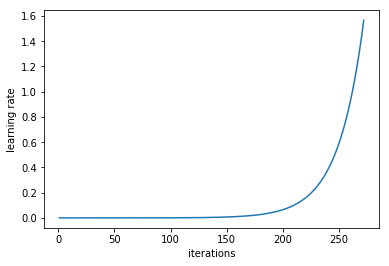

In [14]:
# look at the learning rate schedule
learn.sched.plot_lr()

Note that in the previous plot *iteration* is one iteration (or *minibatch*) of SGD. In one epoch there are 
(num_train_samples/num_iterations) of SGD.

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

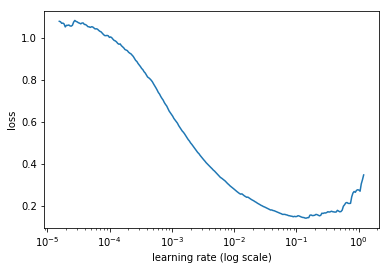

In [15]:
learn.sched.plot()

The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use. Note that the optimal learning rate can change as we train the model, so you may want to re-run this function from time to time.

### Add data augmentations
to reduce overfitting/improve generalization

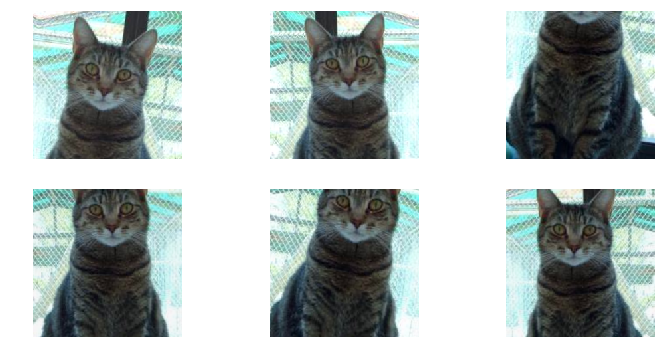

In [16]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

### Train final layer with caching of frozen layers for speed

In [17]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.060816   0.0242     0.9926    



[array([0.0242]), 0.9926]

#### check current validation results

In [18]:
# predict on validation set (in log scale)
log_preds = learn.predict()
log_preds.shape
log_preds[:10]
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

(5000, 2)

array([[ -0.00051,  -7.57253],
       [ -0.00016,  -8.75534],
       [ -0.0001 ,  -9.20145],
       [ -0.00003, -10.53811],
       [ -0.00001, -11.28524],
       [ -0.00312,  -5.77109],
       [ -0.00014,  -8.8661 ],
       [ -0.00002, -10.70728],
       [ -0.00009,  -9.36132],
       [ -0.01318,  -4.33601]], dtype=float32)

Correctly classified


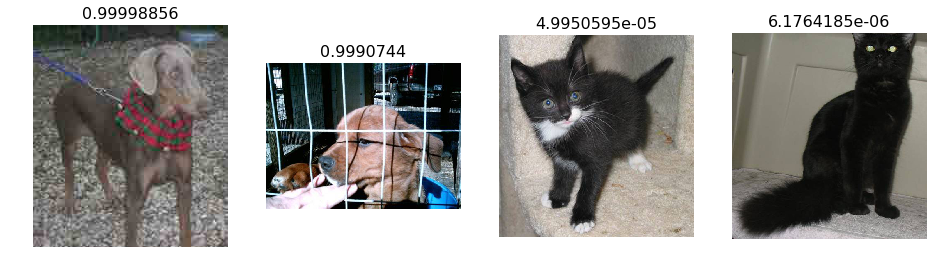

In [19]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


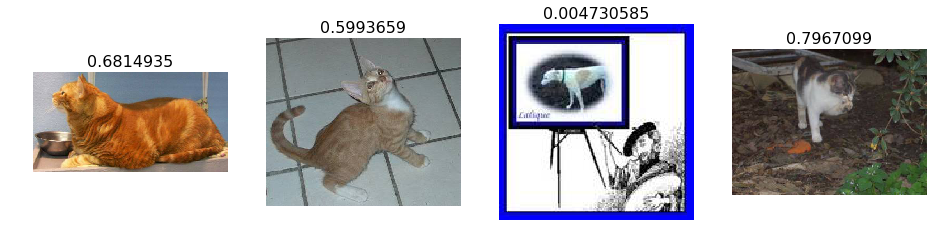

In [20]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

Most correct cats


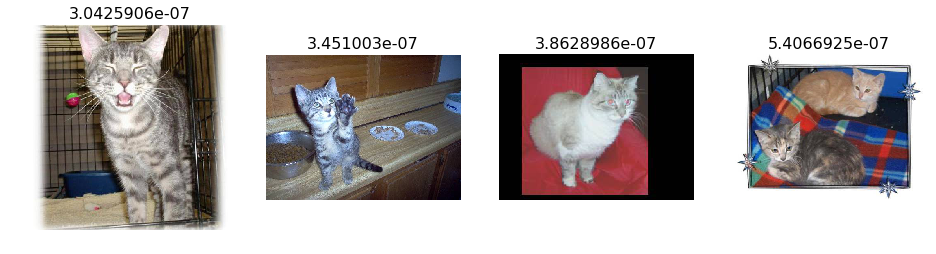

In [21]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


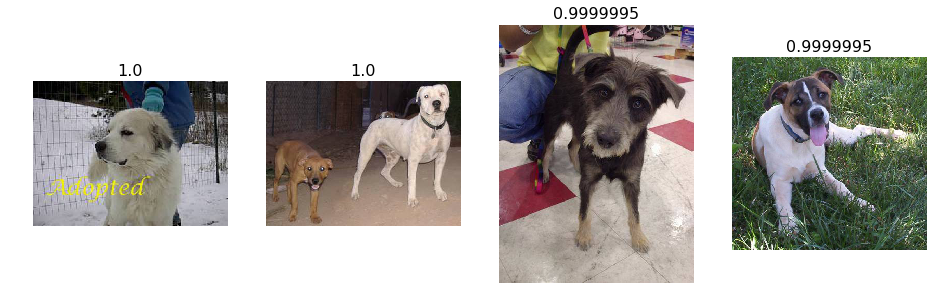

In [22]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


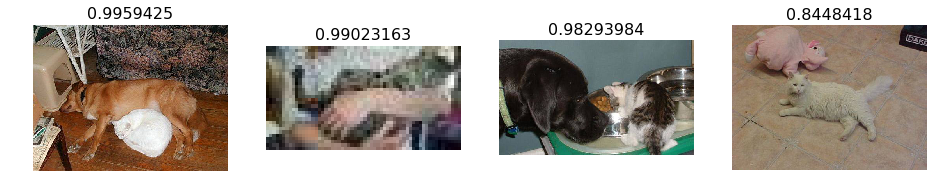

In [23]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


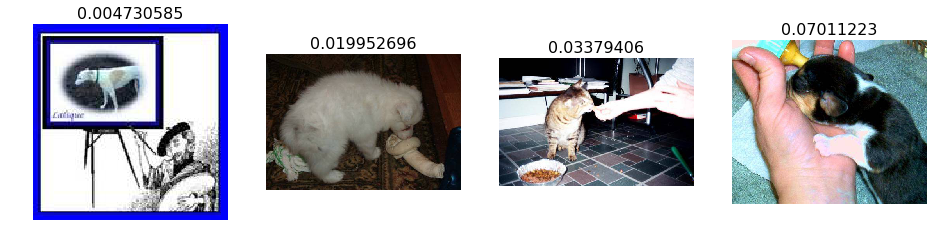

In [24]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


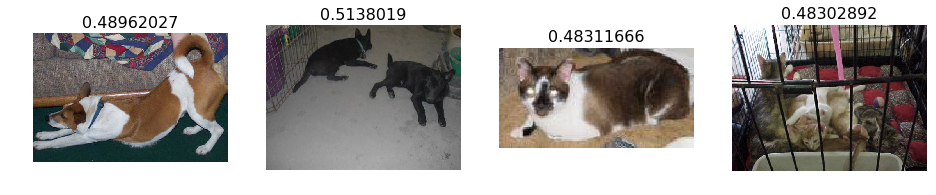

In [25]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

### Turn off caching of frozen layers (to enable data augmentation), add SGDR (cyclic LR schedule), continue training final layer

epoch      trn_loss   val_loss   accuracy                     
    0      0.05361    0.020342   0.9938    
    1      0.052055   0.019569   0.993                        
    2      0.048916   0.019144   0.993                        



[array([0.01914]), 0.993]

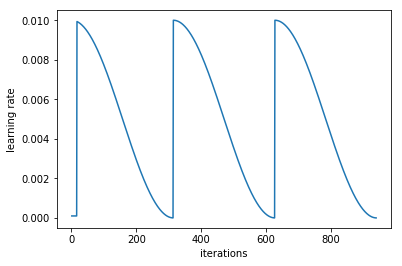

In [26]:
learn.precompute=False
# reset lr every epoch, for 3 cycles total
learn.fit(1e-2, 3, cycle_len=1)
learn.sched.plot_lr()
learn.save('224_lastlayer')
learn.load('224_lastlayer')

### Fine-tune other layers using differential learning rates and learning rate cycle multipler (to slow down resets as training progresses)

Final layer is now fully trained. Other layers have already been trained to recognize imagenet photos (whereas final layers were randomly initialized), so don't want to destroy the carefully tuned weights that are already there. The earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before.

In [27]:
# recheck optimal learning rate
learn.unfreeze()
lrf=learn.lr_find()

 68%|██████▊   | 212/313 [01:20<00:38,  2.63it/s, loss=0.297] 

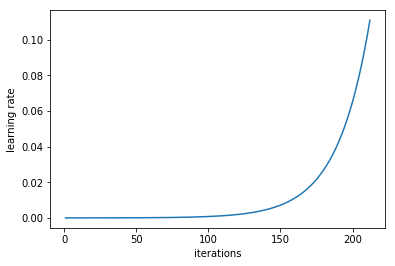

In [28]:
learn.sched.plot_lr()

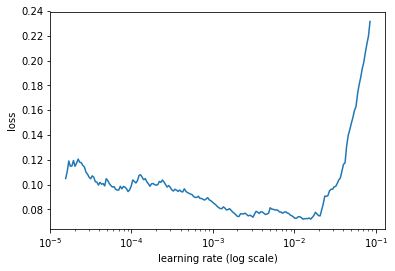

In [29]:
learn.sched.plot()

In [ ]:
# train
lr=np.array([5e-4,5e-3,5e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_lr()
learn.save('224_all')
learn.load('224_all')

 68%|██████▊   | 212/313 [01:21<00:38,  2.61it/s, loss=0.0744]

Note: plot above is the final layers. Learning rates of earlier layers are set to fractions of the final layers rates.

### Check and analyze results on validation set using test time augmentation
Make predictions on a number of randomly augmented versions of validation set, then use the average prediction

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)
preds = np.argmax(probs, axis=1)
probs = probs[:,1]
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

### Looking at pictures again

In [ ]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

### Compare validation results to other models
### If this model is best, retrain on full training set, predict on test set, submit

check submission example, format with kaggle

try using kaggle python api


should set above up so it renames train to full_train  
then COPIES to train/valid

#### Copy validation data back to `TRAIN_PATH` in order to train on full data

In [ ]:
!cp {TRAIN_DOG_PATH}/*.jpg {TRAIN_DOG_PATH}
!cp {TRAIN_CAT_PATH}/*.jpg {TRAIN_CAT_PATH}

!ls {TRAIN_DOG_PATH} | wc -l
!ls {TRAIN_CAT_PATH} | wc -l

### Retrain on all data

### Submit to Kaggle
list top results